In [1]:
import os
# Désactive la vérification stricte des types de jaxtyping/beartype
os.environ["JAXTYPING_DISABLE"] = "1"

import torch
import skshapes as sks
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


## Fonctions utilitaires

In [3]:
def plot_polydata_2d(shape, ax, color, label, linestyle='-'):
    """
    Fonction utilitaire pour tracer un contour PolyData 2D avec matplotlib.
    """
    # 1. Récupérer les points du Tenseur PyTorch vers NumPy
    points_np = shape.points.numpy()
    
    # 2. Séparer X et Y
    x = points_np[:, 0]
    y = points_np[:, 1]
    
    # 3. ASTUCE : Fermer la boucle pour l'affichage
    # On rajoute le premier point à la fin de la liste
    x_plot = np.append(x, x[0])
    y_plot = np.append(y, y[0])
    
    # 4. Tracer
    ax.plot(x_plot, y_plot, color=color, label=label, linewidth=2, linestyle=linestyle)
    # Optionnel : afficher les points individuels
    # ax.scatter(x, y, color=color, s=10)

## Création des formes jouet et affichage

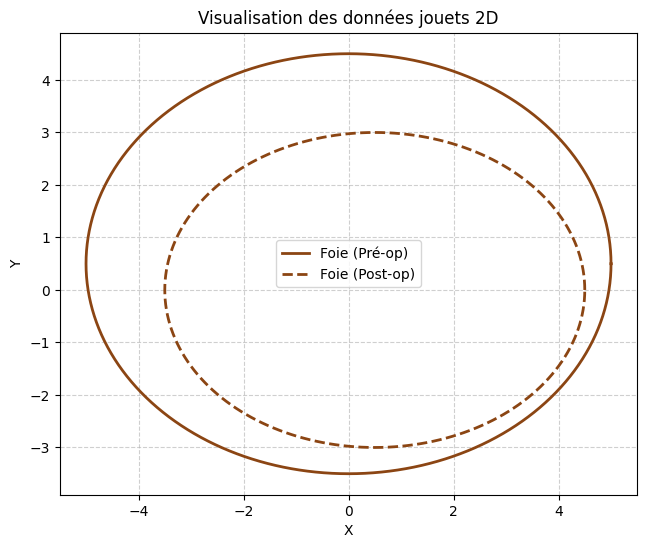

In [4]:
# paramètres forme 1
Dx1 = 10
Dy1 = 8
x1 = 0
y1 = 0
# paramètres forme 1
x2 = 0.5
y2 = 0
Dx2 = 8
Dy2 = 6
# Créer le Foie (une grosse ellipse un peu déformée)
liver1 = sks.Circle(n_points=200)
liver1.points = liver1.points + torch.tensor([-0.5, -0.5])
liver1.points = liver1.points * torch.tensor([Dx1, Dy1])
liver1.points = liver1.points + torch.tensor([x1, x2])
liver2 = sks.Circle(n_points=200)
liver2.points = liver2.points + torch.tensor([-0.5, -0.5])
liver2.points = liver2.points * torch.tensor([Dx2, Dy2])
liver2.points = liver2.points + torch.tensor([x2, y2])

# Création de la figure
fig, ax = plt.subplots(figsize=(8, 6))

# Tracer le foie
plot_polydata_2d(liver1, ax, color='saddlebrown', label='Foie (Pré-op)')
plot_polydata_2d(liver2, ax, color='saddlebrown', label='Foie (Post-op)', linestyle='--')


# Réglages importants
ax.set_aspect('equal')  # CRUCIAL : pour que les cercles ne ressemblent pas à des ellipses
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()
plt.title("Visualisation des données jouets 2D")
plt.xlabel("X")
plt.ylabel("Y")

plt.show()

## Registration

In [5]:
source = liver1
target = liver2

source.control_points = source.bounding_grid(N=10, offset=0.05)

model = sks.ExtrinsicDeformation(n_steps=5, kernel="gaussian", scale=8, control_points=True)
loss = sks.VarifoldLoss(radial_bandwidth=2.0)

registration = sks.Registration(
    model=model,
    loss=loss,
    optimizer=sks.LBFGS(),
    n_iter=1,
    verbose=True,
    regularization_weight=0,
)

morphed = registration.fit_transform(source=source, target=target)

[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula Exp(-Sum((a-b)**2))*c with a=Var(0,2,0), b=Var(1,2,1), c=Var(2,2,1) ... OK
[pyKeOps] Compiling pykeops cpp d7376291f3 module ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula (-2*((a-b)*(d|c)))*Exp(-Sum((a-b)**2)) with a=Var(0,2,0), b=Var(1,2,1), c=Var(2,2,1), d=Var(3,2,0) ... OK
[pyKeOps] Compiling pykeops cpp bbb230619a module ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 1) of formula (2*((a-b)*(d|c)))*Exp(-Sum((a-b)**2)) with a=Var(0,2,0), b=Var(1,2,1), c=Var(2,2,1), d=Var(3,2,0) ... OK
[pyKeOps] Compiling pykeops cpp 3068b15b39 module ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 1) of formula Exp(-Sum((a-b)**2))*d with a=Var(0,2,0), b=Var(1,2,1), d=Var(3,2,0) ... OK
[pyKeOps] Compiling pykeops cpp b483d777fd module ... OK


ValueError: Dimension of source and target must be 3 to compute varifold loss. Found 2 for source, 2 for target

Correction : La grille de contrôle était en 2D, conversion en 3D...
Démarrage du recalage...
[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula Exp(-Sum((a-b)**2))*c with a=Var(0,3,0), b=Var(1,3,1), c=Var(2,3,1) ... OK
[pyKeOps] Compiling pykeops cpp 1129d0aed7 module ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula (-2*((a-b)*(d|c)))*Exp(-Sum((a-b)**2)) with a=Var(0,3,0), b=Var(1,3,1), c=Var(2,3,1), d=Var(3,3,0) ... OK
[pyKeOps] Compiling pykeops cpp 552442b0fd module ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 1) of formula (2*((a-b)*(d|c)))*Exp(-Sum((a-b)**2)) with a=Var(0,3,0), b=Var(1,3,1), c=Var(2,3,1), d=Var(3,3,0) ... OK
[pyKeOps] Compiling pykeops cpp 815f898eeb module ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 1) of formula Exp(-Sum((a-b)**2))*d with a=Var(0,3,0), b=Var(1,3,1), d=Var(3,3,0) ... OK
[pyKeOps] Compiling pykeops cpp 48893dac09 

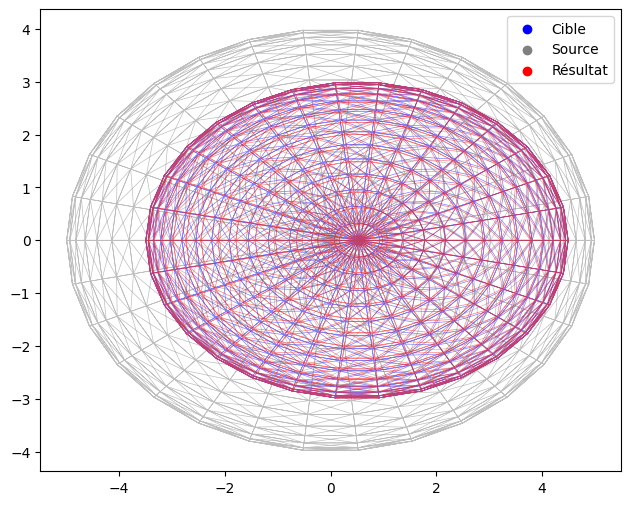

In [8]:
import os
os.environ["JAXTYPING_DISABLE"] = "1" 

import torch
import skshapes as sks
import matplotlib.pyplot as plt
import numpy as np

# 1. CRÉATION DES DONNÉES (Sphères aplaties en 3D)
liver1 = sks.Sphere() 
liver1.points = liver1.points * torch.tensor([10.0, 8.0, 0.0]) 

liver2 = sks.Sphere()
liver2.points = liver2.points * torch.tensor([8.0, 6.0, 0.0])
liver2.points = liver2.points + torch.tensor([0.5, 0.0, 0.0])

source = liver1
target = liver2

# 2. GÉNÉRATION DE LA GRILLE
source.control_points = source.bounding_grid(N=10, offset=0.5)

# ============================================================
# 🚨 CORRECTIF : FORCER LA GRILLE EN 3D
# ============================================================
# Si la grille a été générée en 2D (N, 2), on rajoute la colonne Z=0
if source.control_points.points.shape[1] == 2:
    print("Correction : La grille de contrôle était en 2D, conversion en 3D...")
    cp_points = source.control_points.points
    # On colle une colonne de zéros à droite
    new_points = torch.cat([cp_points, torch.zeros(cp_points.shape[0], 1)], dim=1)
    source.control_points.points = new_points

# On vérifie aussi que la source est bien en 3D (au cas où)
if source.points.shape[1] == 2:
    source.points = torch.cat([source.points, torch.zeros(source.n_points, 1)], dim=1)
# ============================================================

# 3. CONFIGURATION DU RECALAGE
model = sks.ExtrinsicDeformation(
    n_steps=10, 
    kernel="gaussian", 
    scale=5.0, 
    control_points=True
)

try:
    loss = sks.VarifoldLoss(radial_bandwidth=2.0)
except:
    loss = sks.Loss(loss_type="varifold", scales=[2.0])

registration = sks.Registration(
    model=model,
    loss=loss,
    optimizer=sks.LBFGS(),
    n_iter=15, 
    verbose=True,
    regularization_weight=0.01 
)

# 4. EXÉCUTION
print("Démarrage du recalage...")
morphed = registration.fit_transform(source=source, target=target)
print("Terminé !")

# 5. VISUALISATION
def plot_mesh_2d(shape, ax, color, label):
    pts = shape.points.detach().numpy()
    triangles = shape.triangles.detach().numpy()
    ax.triplot(pts[:, 0], pts[:, 1], triangles, color=color, alpha=0.5, linewidth=0.5)
    ax.scatter([], [], color=color, label=label)

fig, ax = plt.subplots(figsize=(8, 6))
plot_mesh_2d(target, ax, color='blue', label='Cible')
plot_mesh_2d(source, ax, color='gray', label='Source')
plot_mesh_2d(morphed, ax, color='red', label='Résultat')
ax.set_aspect('equal')
ax.legend()
plt.show()

In [1]:
import os
# ============================================================
# 1. CONFIGURATION (CRUCIAL : AVANT LES IMPORTS)
# ============================================================
# Désactive le vérificateur de type strict qui causait les plantages
os.environ["JAXTYPING_DISABLE"] = "1" 

import torch
import skshapes as sks
import pyvista as pv
import numpy as np

# ============================================================
# 2. GÉNÉRATION DES DONNÉES (MODE 3D APLATI)
# ============================================================
print("--- Génération des formes ---")

# On utilise sks.Sphere() qui génère un maillage 3D valide (points + triangles)
# Cela évite les erreurs de dimension avec la VarifoldLoss
base_sphere = sks.Sphere()

# --- FORME 1 : SOURCE (Pré-op : Foie + Tumeur) ---
# On crée une nouvelle sphère
liver1 = sks.Sphere() 
# On l'aplatit (Z=0) et on l'étire (X=10, Y=8)
liver1.points = liver1.points * torch.tensor([10.0, 8.0, 0.0]) 
liver1.points = liver1.points + torch.tensor([0.0, 0.0, 0.0]) # Centré en 0,0

# --- FORME 2 : CIBLE (Post-op : Foie Rétracté) ---
liver2 = sks.Sphere()
# Plus petit (X=8, Y=6) et décalé
liver2.points = liver2.points * torch.tensor([8.0, 6.0, 0.0])
liver2.points = liver2.points + torch.tensor([0.5, 0.0, 0.0]) 

# Assignation explicite
source = liver1
target = liver2

# ============================================================
# 3. CONFIGURATION DU RECALAGE
# ============================================================
print("--- Configuration du modèle ---")

# A. Points de contrôle (Grille)
# On génère la grille autour de la source
source.control_points = source.bounding_grid(N=10, offset=0.5)

# B. Correction de la grille (Sécurité 2D -> 3D)
# Si la grille générée est plate (N, 2), on force (N, 3) pour éviter le crash
if source.control_points.points.shape[1] == 2:
    print("   -> Conversion de la grille de contrôle en 3D...")
    cp = source.control_points.points
    source.control_points.points = torch.cat([cp, torch.zeros(cp.shape[0], 1)], dim=1)

# C. Modèle de Déformation (LDDMM)
model = sks.ExtrinsicDeformation(
    n_steps=10,             # Fluidité de la déformation
    kernel="gaussian",      # Type de noyau
    scale=5.0,              # Rigidité (plus grand = déformation plus globale)
    control_points=True
)

# D. Fonction de Coût (Varifold)
# Gestion robuste des versions de la librairie
try:
    loss = sks.VarifoldLoss(radial_bandwidth=2.0)
except (AttributeError, TypeError):
    loss = sks.Loss(loss_type="varifold", scales=[2.0])

# E. Objet Registration
registration = sks.Registration(
    model=model,
    loss=loss,
    optimizer=sks.LBFGS(),
    n_iter=15,              # Nombre d'itérations
    verbose=True,           # Afficher la progression
    regularization_weight=0.1 # Pénalité de déformation (0.1 = équilibré)
)

# ============================================================
# 4. EXÉCUTION
# ============================================================
print("--- Démarrage du recalage ---")
morphed = registration.fit_transform(source=source, target=target)
print("--- Terminé ! ---")

# ============================================================
# 5. VISUALISATION INTERACTIVE (PYVISTA)
# ============================================================
print("--- Ouverture de la fenêtre 3D ---")

# Conversion en objets PyVista
pv_target = target.to_pyvista()   # Cible (Bleu)
pv_source = source.to_pyvista()   # Source (Gris/Fil de fer)
pv_morphed = morphed.to_pyvista() # Résultat (Rouge)

# Création de la scène (2 vues côte à côte)
plotter = pv.Plotter(shape=(1, 2))

# Vue de Gauche : Avant
plotter.subplot(0, 0)
plotter.add_text("AVANT Recalage", font_size=10)
plotter.add_mesh(pv_target, color="blue", opacity=0.3, label="Cible (Post-op)")
plotter.add_mesh(pv_source, color="silver", style="wireframe", line_width=2, label="Source (Pré-op)")
plotter.add_legend()

# Vue de Droite : Après
plotter.subplot(0, 1)
plotter.add_text("APRÈS Recalage", font_size=10)
plotter.add_mesh(pv_target, color="blue", opacity=0.3, label="Cible")
plotter.add_mesh(pv_morphed, color="red", opacity=0.8, show_edges=True, label="Recalé")
plotter.add_legend()

# Lier les caméras pour zoomer sur les deux en même temps
plotter.link_views()

plotter.show()

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
--- Génération des formes ---
--- Configuration du modèle ---
   -> Conversion de la grille de contrôle en 3D...
--- Démarrage du recalage ---
Initial loss : 3.70e+02
  = 3.70e+02 + 0.1 * 0.00e+00 (fidelity + regularization_weight * regularization)
Loss after 1 iteration(s) : 3.63e-01
  = 9.77e-04 + 0.1 * 3.62e+00 (fidelity + regularization_weight * regularization)
Loss after 2 iteration(s) : 3.63e-01
  = 9.77e-04 + 0.1 * 3.62e+00 (fidelity + regularization_weight * regularization)
Loss after 3 iteration(s) : 3.63e-01
  = 9.77e-04 + 0.1 * 3.62e+00 (fidelity + regularization_weight * regularization)
Loss after 4 iteration(s) : 3.63e-01
  = 9.77e-04 + 0.1 * 3.62e+00 (fidelity + regularization_weight * regularization)
Loss after 5 iteration(s) : 3.63e-01
  = 9.77e-04 + 0.1 * 3.62e+00 (fidelity + regularization_weight * regularization)
Loss after 6 iteration(s) : 3.63e-01
  = 9.77e-04 + 0.1 * 3.62e+00

Widget(value='<iframe src="http://localhost:52491/index.html?ui=P_0x166a19910_0&reconnect=auto" class="pyvista…

In [10]:
%pip install trame trame-vuetify trame-vtk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 22.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.0/781.0 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.1/245.1 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 5.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


##